## Importing libraries

In [1]:
!pip install torch
!pip install torchvision
!pip install timm
!pip install matplotlib

from typing import Dict, List
from tqdm.auto import tqdm
import os

import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets,transforms
from torchvision import datasets

import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
device

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 56.1 MB/s eta 0:00:00


'cuda'

## Pretrain Vit Model Definition

In [2]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

pretrained_vit.heads = nn.Linear(in_features=768,out_features=3).to(device)

for param in pretrained_vit.heads.parameters():
    param.requires_grad = True

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:05<00:00, 58.3MB/s]


## Data Loaders Preparation

In [5]:
!unzip -o /content/dataset2.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/train/happy/im1416.png  
  inflating: dataset/train/happy/im7067.png  
  inflating: dataset/train/happy/im3201.png  
  inflating: dataset/train/happy/im5670.png  
  inflating: dataset/train/happy/im2490.png  
  inflating: dataset/train/happy/im3956.png  
  inflating: dataset/train/happy/im1199.png  
  inflating: dataset/train/happy/im6190.png  
  inflating: dataset/train/happy/im393.png  
  inflating: dataset/train/happy/im1827.png  
  inflating: dataset/train/happy/im4787.png  
  inflating: dataset/train/happy/im5499.png  
  inflating: dataset/train/happy/im75.png  
  inflating: dataset/train/happy/im4793.png  
  inflating: dataset/train/happy/im61.png  
  inflating: dataset/train/happy/im6184.png  
  inflating: dataset/train/happy/im1833.png  
  inflating: dataset/train/happy/im387.png  
  inflating: dataset/train/happy/im2484.png  
  inflating: dataset/train/happy/im3942.png  
  inflating: dataset/train/happy/im

In [21]:
train_dir = "/content/dataset/train"
test_dir = "/content/dataset/test"

pretrained_vit_transforms = pretrained_vit_weights.transforms()
from torchvision.transforms import InterpolationMode

train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize([224]),
    torchvision.transforms.ColorJitter(brightness=0.5),
    torchvision.transforms.ToTensor(),
])

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize([224]),
    torchvision.transforms.ToTensor(),
])


train_data = datasets.ImageFolder(root=train_dir,
                                        transform=train_transforms,
                                        target_transform=None,
                                        )
test_data = datasets.ImageFolder(root=test_dir,
                                      transform = test_transforms)
train_data.classes

['happy', 'sad']

In [24]:
BATCH_SIZE= 32
NUM_WORKERS= os.cpu_count()

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers = NUM_WORKERS
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

In [25]:
print(f"test dataset size: {len(train_dataloader)}, train dataset size: {len(test_dataloader)}")

test dataset size: 377, train dataset size: 95


In [26]:
img,label = next(iter(train_dataloader))
img.shape,label.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

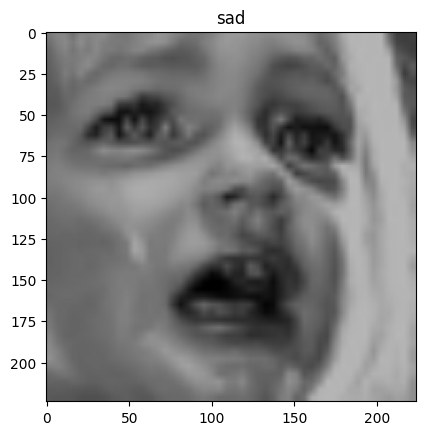

In [30]:
image_batch,label_batch = next(iter(train_dataloader))
img,label = image_batch[0],label_batch[0]
img.shape,label
import matplotlib.pyplot as plt

class_names = train_data.classes
plt.imshow(img.permute(1,2,0))
plt.title(class_names[label]);

## Training

In [31]:
# from typing import Dict, List
# from tqdm.auto import tqdm

from typing import Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:

    model.train()
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:

    model.eval()
    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc


def train_vit(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List[float]]:

    results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
    }

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results




In [32]:
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()


pretrained_vit_results = train_vit(model=pretrained_vit,
                                      train_dataloader=train_dataloader,
                                      test_dataloader=test_dataloader,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4216 | train_acc: 0.8065 | test_loss: 0.4159 | test_acc: 0.8122
Epoch: 2 | train_loss: 0.3964 | train_acc: 0.8254 | test_loss: 0.3952 | test_acc: 0.8165
Epoch: 3 | train_loss: 0.3807 | train_acc: 0.8310 | test_loss: 0.3893 | test_acc: 0.8278
Epoch: 4 | train_loss: 0.3711 | train_acc: 0.8337 | test_loss: 0.3788 | test_acc: 0.8290
Epoch: 5 | train_loss: 0.3643 | train_acc: 0.8351 | test_loss: 0.3774 | test_acc: 0.8357
Epoch: 6 | train_loss: 0.3609 | train_acc: 0.8418 | test_loss: 0.3728 | test_acc: 0.8326
Epoch: 7 | train_loss: 0.3584 | train_acc: 0.8387 | test_loss: 0.3664 | test_acc: 0.8326
Epoch: 8 | train_loss: 0.3506 | train_acc: 0.8445 | test_loss: 0.3700 | test_acc: 0.8430
Epoch: 9 | train_loss: 0.3474 | train_acc: 0.8486 | test_loss: 0.3673 | test_acc: 0.8392
Epoch: 10 | train_loss: 0.3429 | train_acc: 0.8496 | test_loss: 0.3694 | test_acc: 0.8331


In [33]:
from pathlib import Path

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):

    # Create target directory
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True,
                        exist_ok=True)

    # Create model save path
    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
    model_save_path = target_dir_path / model_name

    # Save the model state_dict()
    print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(),
             f=model_save_path)

In [34]:
save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor.pth")

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor.pth
